# Monowai CC tests

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
import os
import xcorr

In [2]:
%matplotlib notebook

### open a file

In [3]:
def filename(path:str, r1:dict, r2:dict, time:pd.datetime):
    pair = '-'.join([xcorr.util.receiver_to_str(r1), xcorr.util.receiver_to_str(r2)])
    return os.path.join(path,pair,'{p}.{y:04d}.{d:03d}.nc'.format(p=pair,y=time.year,d=time.dayofyear))

In [4]:
path = '/Users/psmets/Documents/Research/_studies/_hydro/monowai_remote/tests/full'
time = pd.to_datetime('2015-01-15')

hydro = {
    'network'  : 'IM',
    'station'  : 'H03S1',
    'location' : '',
    'channel'  : 'EDH',
}
seism = {
    'network'  : 'IU',
    'station'  : 'RAR',
    'location' : '10',
    'channel'  : 'BHZ',
}

vel = dict( min=1.46, max=1.50 )

bhz = xcorr.read(filename(path, hydro, seism, time), fast=True)
bhr = xcorr.read(filename(path, hydro, {**seism,'channel':'BHR'}, time), fast=True)

assert bhz, 'No data found!'

if bhz:
    xcorr.bias_correct(bhz,unbiased_var='cc_w')
if bhr:
    xcorr.bias_correct(bhr,unbiased_var='cc_w')

### CCF noise window

<IPython.core.display.Javascript object>


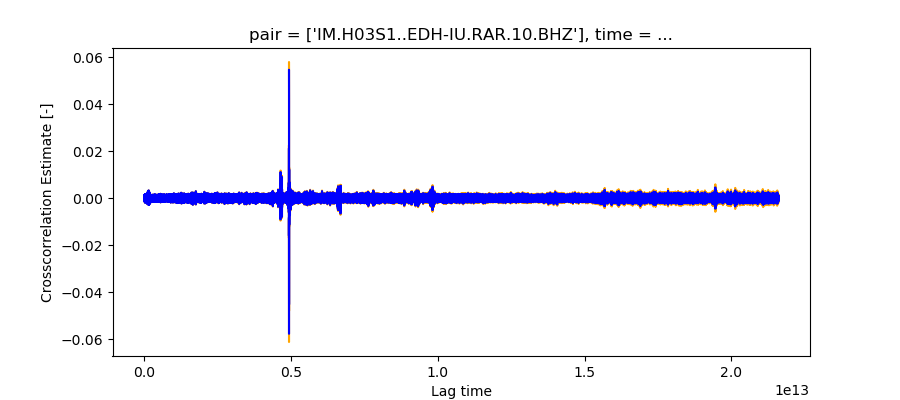

In [5]:
plt.figure(figsize=[9,4])
bhz.cc_w.loc[{'time':bhz.time[1]}].plot.line(x='lag',add_legend=False,color='orange')
bhz.cc.loc[{'time':bhz.time[1]}].plot.line(x='lag',add_legend=False,color='blue')

In [13]:
noise_win = xcorr.signal.mask(
    x=bhz.lag,
    lower=.2,
    upper=.25,
    scalar=bhz.time.window_length
)

signal_win = xcorr.signal.mask(
    x=bhz.lag,
    lower=1/vel['max'],
    upper=1/vel['min'],
    scalar=bhz.distance.values[0]
)

valid_win = xcorr.signal.mask(
    x=bhz.lag,
    upper=.25,
    scalar=bhz.time.window_length
)

i = 1

17280.0 21600.0
4876.97376465242 5010.5894842319385


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [10]:
valid_win.history

'xcorr-0.1.dev84+g676dada.d20200327: mask({"x":"lag (lag)","lower":null,"upper":0.25,"scalar":86400.0,"invert":false,"name":null,"to_where":false,"**kwargs":{}})'

<IPython.core.display.Javascript object>


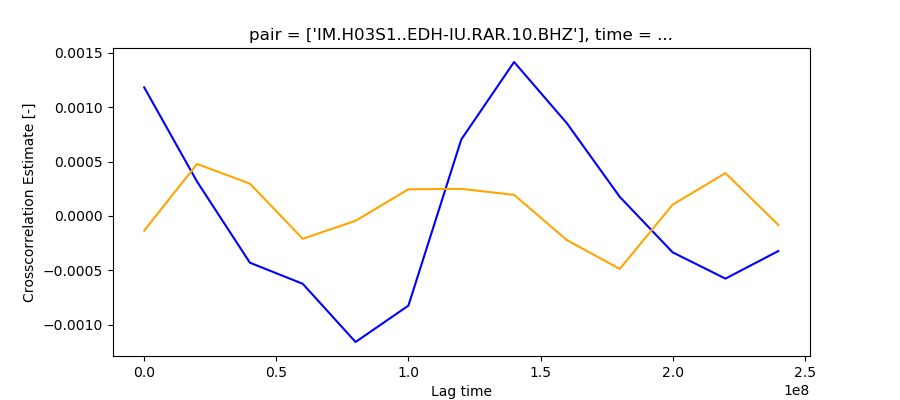

In [8]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc.loc[{'time':bhr.time[i],'lag':bhr.lag[valid_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc.loc[{'time':bhz.time[i],'lag':bhz.lag[valid_win]}].plot.line(x='lag',add_legend=False,color='orange')

In [ ]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc.loc[{'time':bhr.time[i],'lag':bhr.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc.loc[{'time':bhz.time[i],'lag':bhz.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='orange')

In [ ]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc_w.loc[{'time':bhr.time[i],'lag':bhr.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc_w.loc[{'time':bhz.time[i],'lag':bhz.lag[signal_win]}].plot.line(x='lag',add_legend=False,color='orange')

In [ ]:
plt.figure(figsize=[9,4])
if bhr:
    bhr.cc_w.loc[{'time':bhr.time[i],'lag':bhr.lag[noise_win]}].plot.line(x='lag',add_legend=False,color='blue')
if bhz:
    bhz.cc_w.loc[{'time':bhz.time[i],'lag':bhz.lag[noise_win]}].plot.line(x='lag',add_legend=False,color='orange')

In [ ]:
if bhz:
    bhz['snr'] = ( 
        xcorr.signal.rms(bhz.cc_w.loc[{'lag':bhz.lag[signal_win]}]) / 
        xcorr.signal.rms(bhz.cc_w.loc[{'lag':bhz.lag[noise_win]}])
    )
    print(bhz.snr)
    
if bhr:
    bhr['snr'] = ( 
        xcorr.signal.rms(bhr.cc_w.loc[{'lag':bhr.lag[signal_win]}]) / 
        xcorr.signal.rms(bhr.cc_w.loc[{'lag':bhr.lag[noise_win]}])
    )
    print(bhr.snr)

### xcorr full day (#8)

In [ ]:
snr_min = 4

plt.figure(figsize=[9,4])
if bhr:
    snr_pass = bhr.snr.loc[{'pair':bhr.pair[0]}] >= snr_min
    if any(snr_pass):
        bhr.cc_w.loc[{
            'time':bhr.time[snr_pass],
            'lag':bhr.lag[signal_win],
            'pair':bhr.pair[0]
        }].plot.line(x='lag',add_legend=False,color='blue',alpha=0.3)
if bhz:
    snr_pass = bhz.snr.loc[{'pair':bhz.pair[0]}] >= snr_min
    if any(snr_pass):
        bhz.cc_w.loc[{
            'time':bhz.time[snr_pass],
            'lag':bhz.lag[signal_win],
            'pair':bhz.pair[0]
        }].plot.line(x='lag',add_legend=False,color='orange',alpha=0.3)

## Filter CC

In [ ]:
bhz['cc_w_f'] = xcorr.signal.filter(bhz.cc_w,btype='bandpass',frequency=[5.,20.])
if bhr:
    bhr['cc_w_f'] = xcorr.signal.filter(bhr.cc_w,btype='bandpass',frequency=[5.,20.])

In [ ]:
bhr.cc_w_f.history

In [ ]:
plt.figure(figsize=[9,4])
bhz.cc_w_f.loc[{'time':bhz.time[1]}].plot.line(x='lag',add_legend=False,color='orange')
bhr.cc_w_f.loc[{'time':bhr.time[1]}].plot.line(x='lag',add_legend=False,color='blue')

In [ ]:
xcorr.write_dataset(bhz,'test.nc')

In [ ]:
test = xcorr.open_dataset('test.nc')

In [ ]:
snr_min = 4

plt.figure(figsize=[9,4])
if bhr:
    snr_pass = bhr.snr.loc[{'pair':bhr.pair[0]}] >= snr_min
    if any(snr_pass):
        bhr.cc_w_f.loc[{
            'time':bhr.time[snr_pass],
            'lag':bhr.lag[signal_win],
            'pair':bhr.pair[0]
        }].plot.line(x='lag',add_legend=False,color='blue',alpha=0.3)
if bhz:
    snr_pass = bhz.snr.loc[{'pair':bhz.pair[0]}] >= snr_min
    if any(snr_pass):
        bhz.cc_w_f.loc[{
            'time':bhz.time[snr_pass],
            'lag':bhz.lag[signal_win],
            'pair':bhz.pair[0]
        }].plot.line(x='lag',add_legend=False,color='orange',alpha=0.3)

In [ ]:
bhz.cc_w_f

## Spectrogram

In [ ]:
psd = xcorr.postprocess.psd(
    bhz.cc_w.loc[{'lag':bhz.lag[signal_win]}],
    duration = 2.,
    padding = 4,
    lag_to_seconds=True
)

In [ ]:
plt.figure()
psd.loc[{'time':psd.time[4],'pair':psd.pair[0]}].plot.imshow(x='lag')

In [ ]:
psd_mean = psd.dropna(dim='lag').sum(dim='time',skipna=True).mean(dim='pair',skipna=True)

In [ ]:
plt.figure()
psd_mean.plot.imshow(x='lag')